In [1]:
!pip install neuralforecast pandas==2.2.1

In [2]:
from sqlalchemy import create_engine
import pandas as pd
import torch

database_url = "sqlite:////content/data.sqlite"
# database_url = "sqlite:///../data/data.sqlite"

engine = create_engine(database_url)

# define hyper paras
use_standard_scaler = True
save_imputed_data = False
notebook_mode = 'train'
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")


In [3]:
query = "select date as ds,global_entry,hkmo_entry,tw_entry from sh_customs_daily_imputed"
data = pd.read_sql_query(query, engine)
original_data = data.copy()

In [4]:
# melting,转换为长格式
df_long = pd.melt(data, id_vars=['ds'], var_name='unique_id', value_name='y')
df_long['ds'] = pd.to_datetime(df_long.ds)

## 使用cross validation选择模型

使用RTX 4070Ti GPU 训练3小时

In [5]:
import os

# 防止gpu内存不足中断训练
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [7]:
from neuralforecast.auto import AutoLSTM, AutoInformer, AutoAutoformer, AutoPatchTST, AutoNHITS
import pandas as pd
from ray import tune
from neuralforecast.core import NeuralForecast


horizon = 30
lstm_config = {
        "input_size": tune.choice([horizon*4, horizon*16, horizon*32]),
        "h": None,
        "encoder_hidden_size": tune.choice([50, 100, 200]),
        "encoder_n_layers": tune.randint(1, 4),
        "context_size": tune.choice([5, 10, 50]),
        "decoder_hidden_size": tune.choice([64, 128, 256]),
        "learning_rate": tune.loguniform(1e-4, 1e-1),
        "max_steps": tune.choice([300, 500, 700]),
        "batch_size": tune.choice([16, 32]),
        "random_seed": 42,
}

informer_config = {
        "input_size": tune.choice([horizon, horizon*2, horizon*3]),
        "h": None,
        "hidden_size": tune.choice([64, 128, 256]),
        "n_head": tune.choice([4, 8]),
        "learning_rate": tune.loguniform(1e-4, 1e-1),
        "scaler_type": tune.choice(["robust", "minmax"]),
        "max_steps": tune.choice([300, 500, 1000]),
        "batch_size": tune.choice([32, 64, 128]),
        "windows_batch_size": tune.choice([128, 256, 512]),
        "random_seed": tune.randint(1, 20),
}

autoformer_config = {
        "input_size": tune.choice([horizon, horizon*2, horizon*3]),
        "h": None,
        "hidden_size": tune.choice([64, 128, 256]),
        "n_head": tune.choice([4, 8]),
        "learning_rate": tune.loguniform(1e-4, 1e-1),
        "scaler_type": tune.choice(["robust", "minmax"]),
        "max_steps": tune.choice([300, 500, 1000]),
        "batch_size": tune.choice([32, 64, 128]),
        "windows_batch_size": tune.choice([128, 256, 512]),
        "random_seed": 42,
}

pathtst_config = {
        "input_size": tune.choice([horizon, horizon*2, horizon*3]),
        "h": None,
        "hidden_size": tune.choice([16, 128, 256]),
        "n_heads": tune.choice([4, 8]),
        "patch_len": tune.choice([16, 24]),
        "learning_rate": tune.loguniform(1e-4, 1e-1),
        "scaler_type": tune.choice(["robust", "minmax"]),
        "revin": True,
        "revin_affine": tune.choice([True, False]),
        "max_steps": tune.choice([500, 1000, 2000]),
        "batch_size": tune.choice([32, 64, 128]),
        "windows_batch_size": tune.choice([128, 256, 512]),
        "random_seed": 42,
}


models = [
    # transformer-based model3
    AutoPatchTST(
        h=horizon,  # input size has a multiplier, 1~5
        config=pathtst_config,
        # loss= 'mae', # default is MAE
        verbose=True,  # track progress
        num_samples=5,  # try 10
        backend='ray'
    ),
    # baseline
    AutoLSTM(
        h=horizon,  # input size has a multiplier, 1~5
        config=lstm_config,
        # loss= 'mae', # default is MAE
        verbose=True,  # track progress
        num_samples=5,  # try 10
        backend='ray'
    ),
    # transformer-based model1
    AutoInformer(
        h=horizon,  # input size has a multiplier, 1~5
        config=informer_config,
        # loss= 'mae', # default is MAE
        verbose=True,  # track progress
        num_samples=5,  # try 10
        backend='ray'
    ),
    # transformer-based model2
    AutoAutoformer(
        h=horizon,  # input size has a multiplier, 1~5
        config=autoformer_config,
        # loss= 'mae', # default is MAE
        verbose=True,  # track progress
        num_samples=5,  # try 10
        backend='ray'
    ),
]

nf = NeuralForecast(
    models=models,
    freq='1D',
)
cross_val = nf.cross_validation(df_long, val_size=int(0.1 * len(df_long)), test_size=int(0.1 * len(df_long)),n_windows=None)

2024-03-18 05:28:08,127	INFO tune.py:592 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-03-18_05-28-08   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 5                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-03-18_05-28-08
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/_train_tune_2024-03-18_05-28-08`

Trial status: 5 PENDING
Current time: 2024-03-18 05:28:08. Total running time: 0s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
+---------------------------------------------------------------------------------------------------------------------------------------------

(_train_tune pid=13053) Seed set to 42
(_train_tune pid=13053) 2024-03-18 05:28:16.021553: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(_train_tune pid=13053) 2024-03-18 05:28:16.021617: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=13053) 2024-03-18 05:28:16.023284: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(_train_tune pid=13053) 2024-03-18 05:28:17.702686: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 53.64it/s, v_num=0, train_loss_step=1.690, train_loss_epoch=1.630]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 54.96it/s, v_num=0, train_loss_step=1.520, train_loss_epoch=1.560, valid_loss=1.07e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 55.16it/s, v_num=0, train_loss_step=1.450, train_loss_epoch=1.490, valid_loss=992.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 54.66it/s, v_num=0, train_loss_step=1.370, train_loss_epoch=1.360, valid_loss=920.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=13053) 
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 32.12it/s, v_num=0, train_loss_step=1.250, train_loss_epoch=1.200, valid_loss=864.0]
Validation: |          | 0/? [00:00<?, 

(_train_tune pid=13053) Seed set to 42


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 50.39it/s, v_num=0, train_loss_step=1.400, train_loss_epoch=1.420]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 40.00it/s, v_num=0, train_loss_step=1.240, train_loss_epoch=1.240, valid_loss=1.03e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 40.07it/s, v_num=0, train_loss_step=1.120, train_loss_epoch=1.080, valid_loss=937.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 55.03it/s, v_num=0, train_loss_step=1.050, train_loss_epoch=1.020, valid_loss=862.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=13053) 
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 25.57it/s, v_num=0, train_loss_step=1.010, train_loss_epoch=1.030, valid_loss=786.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<00:00

(_train_tune pid=13053) Seed set to 42


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 47.29it/s, v_num=0, train_loss_step=1.780, train_loss_epoch=1.810]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 54.51it/s, v_num=0, train_loss_step=1.620, train_loss_epoch=1.640, valid_loss=1.38e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 53.37it/s, v_num=0, train_loss_step=1.470, train_loss_epoch=1.530, valid_loss=1.52e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=13053) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 38.19it/s, v_num=0, train_loss_step=1.480, train_loss_epoch=1.460, valid_loss=1.25e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 56.09it/s, v_num=0, train_loss_step=1.400, train_loss_epoch=1.390, valid_loss=1.27e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|        

(_train_tune pid=13053) Seed set to 42


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 49.13it/s, v_num=0, train_loss_step=1.180, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 23.41it/s, v_num=0, train_loss_step=1.180, train_loss_epoch=1.180, valid_loss=941.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=13053) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 47.50it/s, v_num=0, train_loss_step=1.140, train_loss_epoch=1.090, valid_loss=884.0]
(_train_tune pid=13053) 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=13053) 
Epoch 328:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.100, train_loss_epoch=1.100, valid_loss=849.0]

Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-03-18 05:30:08. Total running time: 2min 0s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 15e0d_00001 wit

(_train_tune pid=13053) Seed set to 42


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 63.01it/s, v_num=0, train_loss_step=0.223, train_loss_epoch=0.218]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=13053) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.51it/s]
(_train_tune pid=13053) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 59.18it/s, v_num=0, train_loss_step=0.206, train_loss_epoch=0.206, valid_loss=1.11e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=13053) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 57.83it/s, v_num=0, train_loss_step=0.197, train_loss_epoch=0.193, valid_loss=1.04e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=13053) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 36.44it/s, v_num=0, train_loss_step=0.191, train_loss_epoch=0.178, valid_loss=

INFO:lightning_fabric.utilities.seed:Seed set to 42


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 54.42it/s, v_num=0, train_loss_step=0.169, train_loss_epoch=0.161, valid_loss=824.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 14.65it/s, v_num=0, train_loss_step=0.169, train_loss_epoch=0.169, valid_loss=805.0]

Trial _train_tune_15e0d_00004 completed after 10 iterations at 2024-03-18 05:31:11. Total running time: 3min 3s
+--------------------------------------------------+
| Trial _train_tune_15e0d_00004 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         3.05425 |
| time_total_s                             23.0656 |
| training_iteration                            10 |
| loss                                     804.716 |
+--------------------------------------------------+

Trial status: 5 TERMINATED
Current time: 2024-03-18 05:31:11. Total running time: 3min 3s
Logical res

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

2024-03-18 05:32:01,697	INFO tune.py:592 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-03-18_05-32-01   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 5                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-03-18_05-32-01
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/_train_tune_2024-03-18_05-32-01`

Trial status: 5 PENDING
Current time: 2024-03-18 05:32:01. Total running time: 0s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
+---------------------------------------------------------------------------------------------------------------------------------------------

(_train_tune pid=14093) Seed set to 42
(_train_tune pid=14093) 2024-03-18 05:32:13.870417: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(_train_tune pid=14093) 2024-03-18 05:32:13.870475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=14093) 2024-03-18 05:32:13.872151: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(_train_tune pid=14093) 2024-03-18 05:32:16.413949: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 82.80it/s, v_num=0, train_loss_step=1.070, train_loss_epoch=0.869]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14093) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 47.18it/s, v_num=0, train_loss_step=1.140, train_loss_epoch=0.998, valid_loss=1.19e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 81.74it/s, v_num=0, train_loss_step=0.942, train_loss_epoch=1.060, valid_loss=1.18e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.43it/s]
(_train_tune pid=14093) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 83.17it/s, v_num=0, train_loss_step=1.030, train_loss_epoch=0.997, valid_loss=1.14e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train

(_train_tune pid=14093) Seed set to 42


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 35.51it/s, v_num=0, train_loss_step=1.180, train_loss_epoch=1.070]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14093) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 37.46it/s, v_num=0, train_loss_step=1.370, train_loss_epoch=0.980, valid_loss=1.43e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14093) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 48.56it/s, v_num=0, train_loss_step=1.130, train_loss_epoch=1.310, valid_loss=1.42e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14093) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 35.76it/s, v_num=0, train_loss_step=1.210, train_loss_epoch=1.020, valid_loss=1.42e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          |

(_train_tune pid=14093) Seed set to 42


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 111.83it/s, v_num=0, train_loss_step=1.090, train_loss_epoch=1.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 127.08it/s, v_num=0, train_loss_step=1.230, train_loss_epoch=0.955, valid_loss=1.32e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.48it/s]
(_train_tune pid=14093) 
Epoch 298:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.070, train_loss_epoch=1.070, valid_loss=1.17e+3]

Trial _train_tune_15dff_00002 completed after 3 iterations at 2024-03-18 05:32:55. Total running time: 53s
+--------------------------------------------------+
| Trial _train_tune_15dff_00002 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         1.07051 |
| time_total_s                             3.35939 |
| training_ite

(_train_tune pid=14093) Seed set to 42


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 120.71it/s, v_num=0, train_loss_step=0.895, train_loss_epoch=1.090, valid_loss=1.17e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 48.20it/s, v_num=0, train_loss_step=0.921, train_loss_epoch=0.906]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 51.90it/s, v_num=0, train_loss_step=0.588, train_loss_epoch=0.624, valid_loss=1.06e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14093) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 66.13it/s, v_num=0, train_loss_step=0.317, train_loss_epoch=0.345, valid_loss=825.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 347:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.280, train_loss_epoch=0.280, valid_loss=624.0]

Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-03-18 05:33:02. Total ru

(_train_tune pid=14093) Seed set to 42


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
                                                                           
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 105.34it/s, v_num=0, train_loss_step=0.989, train_loss_epoch=0.979]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 109.38it/s, v_num=0, train_loss_step=1.020, train_loss_epoch=1.040, valid_loss=1.18e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 62.18it/s, v_num=0, train_loss_step=0.936, train_loss_epoch=1.050, valid_loss=1.14e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14093) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 72.34it/s, v_num=0, train_loss_step=0.972, train_loss_epoch=1.020, valid_loss=1.14e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_

INFO:lightning_fabric.utilities.seed:Seed set to 42


Epoch 498: 100%|██████████| 1/1 [00:00<00:00, 38.27it/s, v_num=0, train_loss_step=0.948, train_loss_epoch=0.948, valid_loss=1.11e+3]

Trial _train_tune_15dff_00004 completed after 5 iterations at 2024-03-18 05:33:12. Total running time: 1min 10s
+--------------------------------------------------+
| Trial _train_tune_15dff_00004 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         1.73114 |
| time_total_s                             6.88852 |
| training_iteration                             5 |
| loss                                     1125.24 |
+--------------------------------------------------+
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 60.80it/s, v_num=0, train_loss_step=1.010, train_loss_epoch=0.948, valid_loss=1.11e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 15.06it/s, v_num=0, train_loss_step=1.010, train_los

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

2024-03-18 05:33:28,839	INFO tune.py:592 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-03-18_05-33-28   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 5                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-03-18_05-33-28
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/_train_tune_2024-03-18_05-33-28`

Trial status: 5 PENDING
Current time: 2024-03-18 05:33:29. Total running time: 0s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
+---------------------------------------------------------------------------------------------------------------------------------------------

(_train_tune pid=14507) Seed set to 1
(_train_tune pid=14507) 2024-03-18 05:33:40.875336: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(_train_tune pid=14507) 2024-03-18 05:33:40.875397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=14507) 2024-03-18 05:33:40.878851: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(_train_tune pid=14507) 2024-03-18 05:33:43.347147: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.16it/s, v_num=0, train_loss_step=1.590, train_loss_epoch=1.630]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14507) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 10.26it/s, v_num=0, train_loss_step=1.570, train_loss_epoch=1.590, valid_loss=1.47e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14507) 
Epoch 204:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.460, train_loss_epoch=1.460, valid_loss=1.46e+3]

Trial status: 1 RUNNING | 4 PENDING
Current time: 2024-03-18 05:33:59. Total running time: 30s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 15e0b_00000 with loss=1463.3681640625 and params={'input_size': 90, 'h': 30, 'hidden_size': 64, 'n_head': 4, 'learning

(_train_tune pid=14507) Seed set to 19


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.04it/s, v_num=0, train_loss_step=0.191, train_loss_epoch=0.193]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14507) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 21.70it/s, v_num=0, train_loss_step=0.167, train_loss_epoch=0.172, valid_loss=975.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14507) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 21.77it/s, v_num=0, train_loss_step=0.148, train_loss_epoch=0.155, valid_loss=934.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14507) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 21.37it/s, v_num=0, train_loss_step=0.146, train_loss_epoch=0.144, valid_loss=1.04e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1

(_train_tune pid=14507) Seed set to 2


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.53it/s, v_num=0, train_loss_step=0.220, train_loss_epoch=0.214]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14507) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 22.61it/s, v_num=0, train_loss_step=0.199, train_loss_epoch=0.189, valid_loss=1.03e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14507) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 19.04it/s, v_num=0, train_loss_step=0.191, train_loss_epoch=0.178, valid_loss=927.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14507) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
(_train_tune pid=14507) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s, v_num=0, train_loss_step=0.191, train_loss_epoch=0.191, valid_loss=93

(_train_tune pid=14507) Seed set to 4


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.03it/s, v_num=0, train_loss_step=1.290, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14507) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 24.68it/s, v_num=0, train_loss_step=1.200, train_loss_epoch=1.170, valid_loss=1.08e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14507) 
Epoch 202:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.200, train_loss_epoch=1.200, valid_loss=967.0]

Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-03-18 05:35:29. Total running time: 2min 0s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 15e0b_00001 with loss=641.1958618164062 and params={'input_size': 60, 'h': 30, 'hidden_size': 256, 'n_head': 8, 'learning_rate': 0.0006635648640801615, 

(_train_tune pid=14507) Seed set to 17


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.79it/s, v_num=0, train_loss_step=0.258, train_loss_epoch=0.261]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14507) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 26.84it/s, v_num=0, train_loss_step=0.242, train_loss_epoch=0.233, valid_loss=1.04e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14507) 
Epoch 299:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.225, train_loss_epoch=0.225, valid_loss=951.0]


INFO:lightning_fabric.utilities.seed:Seed set to 19


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s, v_num=0, train_loss_step=0.238, train_loss_epoch=0.225, valid_loss=951.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14507) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  5.30it/s, v_num=0, train_loss_step=0.238, train_loss_epoch=0.238, valid_loss=898.0]

Trial _train_tune_15e0b_00004 completed after 3 iterations at 2024-03-18 05:35:56. Total running time: 2min 27s
+--------------------------------------------------+
| Trial _train_tune_15e0b_00004 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         4.01764 |
| time_total_s                             12.9361 |
| training_iteration                             3 |
| loss                                      897.94 |
+--------------------------------------------------+

Trial status:

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

2024-03-18 05:37:31,200	INFO tune.py:592 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-03-18_05-37-31   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 5                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-03-18_05-37-31
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/_train_tune_2024-03-18_05-37-31`

Trial status: 5 PENDING
Current time: 2024-03-18 05:37:31. Total running time: 0s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
+---------------------------------------------------------------------------------------------------------------------------------------------

(_train_tune pid=15549) Seed set to 42
(_train_tune pid=15549) 2024-03-18 05:37:42.999009: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(_train_tune pid=15549) 2024-03-18 05:37:42.999069: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=15549) 2024-03-18 05:37:43.001619: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(_train_tune pid=15549) 2024-03-18 05:37:45.201527: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 13.79it/s, v_num=0, train_loss_step=0.233, train_loss_epoch=0.224]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=15549) 
Epoch 138:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.213, train_loss_epoch=0.213, valid_loss=1.25e+3]

Trial status: 1 RUNNING | 4 PENDING
Current time: 2024-03-18 05:38:01. Total running time: 30s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 15e0c_00000 with loss=1251.9219970703125 and params={'input_size': 60, 'h': 30, 'hidden_size': 128, 'n_head': 8, 'learning_rate': 0.0011783607572664894, 'scaler_type': 'minmax', 'max_steps': 1000, 'batch_size': 128, 'windows_batch_size': 256, 'random_seed': 42, 'loss': MAE(), 'valid_loss': MAE()}
+--------------------------------------------------------------------------------------

(_train_tune pid=15549) Seed set to 42


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 18.42it/s, v_num=0, train_loss_step=1.620, train_loss_epoch=1.590]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=15549) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 20.58it/s, v_num=0, train_loss_step=1.450, train_loss_epoch=1.460, valid_loss=1.29e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=15549) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=15549) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 20.21it/s, v_num=0, train_loss_step=1.290, train_loss_epoch=1.260, valid_loss=1.17e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=15549) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s, v_num=0, train_loss_step=1.220, train_loss_epoch=1.210, valid_loss=1.08e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataL

(_train_tune pid=15549) Seed set to 42


(_train_tune pid=15549) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
                                                                           
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.28it/s, v_num=0, train_loss_step=1.780, train_loss_epoch=1.650]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=15549) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 16.44it/s, v_num=0, train_loss_step=1.630, train_loss_epoch=1.650, valid_loss=1.16e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=15549) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 19.13it/s, v_num=0, train_loss_step=1.590, train_loss_epoch=1.620, valid_loss=1.09e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=15549) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  2.63

(_train_tune pid=15549) Seed set to 42


Epoch 92:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.256, train_loss_epoch=0.256]

Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-03-18 05:40:31. Total running time: 3min 0s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 15e0c_00001 with loss=864.5064697265625 and params={'input_size': 60, 'h': 30, 'hidden_size': 64, 'n_head': 4, 'learning_rate': 0.006295989300272319, 'scaler_type': 'robust', 'max_steps': 1000, 'batch_size': 128, 'windows_batch_size': 256, 'random_seed': 42, 'loss': MAE(), 'valid_loss': MAE()}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         input_size     hidden_size     n_head     learning_rate   scaler_type       max_steps     batch_size     windows_batch_size     iter     to

(_train_tune pid=15549) Seed set to 42


(_train_tune pid=15549) 
Epoch 27:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=147.0, train_loss_epoch=147.0]

Trial status: 4 TERMINATED | 1 RUNNING
Current time: 2024-03-18 05:41:32. Total running time: 4min 0s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 15e0c_00001 with loss=864.5064697265625 and params={'input_size': 60, 'h': 30, 'hidden_size': 64, 'n_head': 4, 'learning_rate': 0.006295989300272319, 'scaler_type': 'robust', 'max_steps': 1000, 'batch_size': 128, 'windows_batch_size': 256, 'random_seed': 42, 'loss': MAE(), 'valid_loss': MAE()}
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         input_size     hidden_size     n_head     learning_rate   scaler_type       max_steps     batch_size     windows_batch_size  

INFO:lightning_fabric.utilities.seed:Seed set to 42


(_train_tune pid=15549) 
Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, v_num=0, train_loss_step=0.286, train_loss_epoch=0.286, valid_loss=1.34e+3]

Trial _train_tune_15e0c_00004 completed after 10 iterations at 2024-03-18 05:42:56. Total running time: 5min 25s
+--------------------------------------------------+
| Trial _train_tune_15e0c_00004 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         8.46233 |
| time_total_s                             87.1893 |
| training_iteration                            10 |
| loss                                     1335.89 |
+--------------------------------------------------+

Trial status: 5 TERMINATED
Current time: 2024-03-18 05:42:56. Total running time: 5min 25s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 15e0c_00001 with loss=864.5064697265625 and params={'input_siz

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

2024-03-18 05:44:32,793	INFO tune.py:592 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-03-18_05-44-32   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 5                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-03-18_05-44-32
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/_train_tune_2024-03-18_05-44-32`

Trial status: 5 PENDING
Current time: 2024-03-18 05:44:33. Total running time: 0s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
+---------------------------------------------------------------------------------------------------------------------------------------------

(_train_tune pid=17367) Seed set to 3
(_train_tune pid=17367) 2024-03-18 05:44:44.691017: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(_train_tune pid=17367) 2024-03-18 05:44:44.691073: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=17367) 2024-03-18 05:44:44.693236: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(_train_tune pid=17367) 2024-03-18 05:44:46.853397: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 62.50it/s, v_num=0, train_loss_step=1.36e+5, train_loss_epoch=4.53e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 60.45it/s, v_num=0, train_loss_step=264.0, train_loss_epoch=248.0, valid_loss=5.73e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 69.65it/s, v_num=0, train_loss_step=104.0, train_loss_epoch=353.0, valid_loss=4.86e+4]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=17367) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 40.74it/s, v_num=0, train_loss_step=177.0, train_loss_epoch=141.0, valid_loss=3.65e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 71.44it/s, v_num=0, train_loss_step=203.0, train_loss_epoch=297.0, valid_loss=7.31e+4]
Validation: |          | 0/? 

(_train_tune pid=17367) Seed set to 13


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 71.38it/s, v_num=0, train_loss_step=2.640, train_loss_epoch=3.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 115: 100%|██████████| 1/1 [00:00<00:00, 38.12it/s, v_num=0, train_loss_step=1.640, train_loss_epoch=1.640, valid_loss=1.96e+3]

Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2024-03-18 05:45:03. Total running time: 30s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 15e09_00001 with loss=1955.9447021484375 and params={'h': 30, 'n_pool_kernel_size': [2, 2, 2], 'n_freq_downsample': [60, 8, 1], 'learning_rate': 0.0327071562333415, 'scaler_type': 'standard', 'max_steps': 1400.0, 'batch_size': 256, 'windows_batch_size': 512, 'loss': MAE(), 'random_seed': 13, 'input_size': 30, 'step_size': 1, 'valid_loss': MAE()}
+--------------------------------------------------------------------------------------------------------------------------------------------------------

(_train_tune pid=17367) Seed set to 6


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 74.62it/s, v_num=0, train_loss_step=4.98e+12, train_loss_epoch=3.95e+12]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=17367) 
Epoch 144:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=6.13e+8, train_loss_epoch=6.13e+8, valid_loss=4.5e+12]

Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2024-03-18 05:45:33. Total running time: 1min 0s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 15e09_00001 with loss=1229.42236328125 and params={'h': 30, 'n_pool_kernel_size': [2, 2, 2], 'n_freq_downsample': [60, 8, 1], 'learning_rate': 0.0327071562333415, 'scaler_type': 'standard', 'max_steps': 1400.0, 'batch_size': 256, 'windows_batch_size': 512, 'loss': MAE(), 'random_seed': 13, 'input_size': 30, 'step_size': 1, 'valid_loss': MAE()}
+------------------------------------------------------------

(_train_tune pid=17367) Seed set to 10


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 59.35it/s, v_num=0, train_loss_step=65.50, train_loss_epoch=85.50]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 75.82it/s, v_num=0, train_loss_step=1.700, train_loss_epoch=1.650, valid_loss=1.53e+4]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 78.21it/s, v_num=0, train_loss_step=1.550, train_loss_epoch=1.620, valid_loss=1.29e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 36.72it/s, v_num=0, train_loss_step=1.580, train_loss_epoch=1.540, valid_loss=1.26e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 67.93it/s, v_num=0, train_loss_step=1.570, train_loss_epoch=1.610, valid_loss=1.28e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<00:00, 66.56it/s, v_num=0, train_loss_step=1.530, train_loss_epoch=1.530, valid_loss=1.

(_train_tune pid=17367) Seed set to 17


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 50.03it/s, v_num=0, train_loss_step=9.73e+6, train_loss_epoch=2.11e+7]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 64.97it/s, v_num=0, train_loss_step=1.08e+7, train_loss_epoch=6.37e+6, valid_loss=2.89e+7]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 293: 100%|██████████| 1/1 [00:00<00:00, 39.18it/s, v_num=0, train_loss_step=5.4e+6, train_loss_epoch=5.4e+6, valid_loss=7.07e+6]

Trial status: 4 TERMINATED | 1 RUNNING
Current time: 2024-03-18 05:46:03. Total running time: 1min 30s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 15e09_00001 with loss=1229.42236328125 and params={'h': 30, 'n_pool_kernel_size': [2, 2, 2], 'n_freq_downsample': [60, 8, 1], 'learning_rate': 0.0327071562333415, 'scaler_type': 'standard', 'max_steps': 1400.0, 'batch_size': 256, 'windows_batch_size': 512, 'loss': MAE(), 'random_seed': 13, 'input_size': 30, 'step_size

INFO:lightning_fabric.utilities.seed:Seed set to 13


Epoch 1099: 100%|██████████| 1/1 [00:00<00:00, 79.26it/s, v_num=0, train_loss_step=4.53e+6, train_loss_epoch=3.8e+6, valid_loss=9.24e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1099: 100%|██████████| 1/1 [00:00<00:00, 28.60it/s, v_num=0, train_loss_step=4.53e+6, train_loss_epoch=4.53e+6, valid_loss=4.7e+6]

Trial _train_tune_15e09_00004 completed after 11 iterations at 2024-03-18 05:46:18. Total running time: 1min 45s
+------------------------------------------------------+
| Trial _train_tune_15e09_00004 result                 |
+------------------------------------------------------+
| checkpoint_dir_name                                  |
| time_this_iter_s                             1.68081 |
| time_total_s                                 20.6074 |
| training_iteration                                11 |
| loss                                     4.69869e+06 |
+------------------------------------------------------+

Trial status: 5 TERMINATED
Current time: 2024-03-18 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

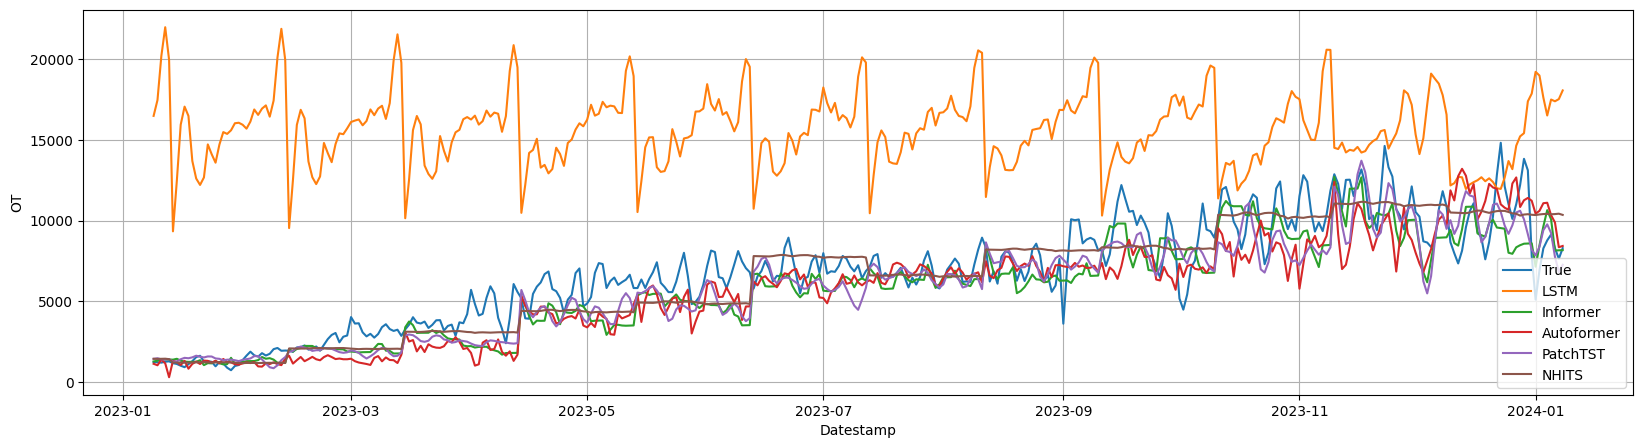

In [16]:
from matplotlib import pyplot as plt

Y_plot = cross_val[cross_val['unique_id'] == 'global_entry']
cutoffs = cross_val['cutoff'].unique()[::horizon]
Y_plot = Y_plot[cross_val['cutoff'].isin(cutoffs)]
Y_plot = Y_plot[-365:]

plt.figure(figsize=(20, 5))
plt.plot(Y_plot['ds'], Y_plot['y'], label='True')
plt.plot(Y_plot['ds'], Y_plot['AutoLSTM'], label='LSTM')
plt.plot(Y_plot['ds'], Y_plot['AutoInformer'], label='Informer')
plt.plot(Y_plot['ds'], Y_plot['AutoAutoformer'], label='Autoformer')
plt.plot(Y_plot['ds'], Y_plot['AutoPatchTST'], label='PatchTST')
plt.plot(Y_plot['ds'], Y_plot['AutoNHITS'], label='NHITS')
plt.xlabel('Datestamp')
plt.ylabel('OT')
plt.grid()
plt.legend()


In [17]:
from neuralforecast.losses.numpy import mae

mae_lstm = mae(cross_val['y'], cross_val['AutoLSTM'])
mae_informer = mae(cross_val['y'], cross_val['AutoInformer'])
mae_autoformer = mae(cross_val['y'], cross_val['AutoAutoformer'])
mae_patchtst = mae(cross_val['y'], cross_val['AutoPatchTST'])
mae_nhits = mae(cross_val['y'], cross_val['AutoNHITS'])

print(f'LSTM: {mae_lstm:.3f}')
print(f'Informer: {mae_informer:.3f}')
print(f'Autoformer: {mae_autoformer:.3f}')
print(f'PatchTST: {mae_patchtst:.3f}')
print(f'NHITS: {mae_nhits:.3f}')


LSTM: 5229.883
Informer: 681.882
Autoformer: 615.653
PatchTST: 484.920
NHITS: 537.364


In [22]:
print(nf.models[0])

AutoPatchTST


In [44]:
reccurrent = 6


df_pred = nf.predict(df_long, step_size=1, random_seed=42)
df_pred['unique_id'] = df_pred.index

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [45]:
df_pred.head()

,ds,AutoPatchTST,AutoLSTM,AutoInformer,AutoAutoformer,AutoNHITS,unique_id
unique_id,,,,,,,
global_entry,2024-02-01,7805.773438,8354.833984,7073.217773,7924.261230,6283.323730,global_entry
global_entry,2024-02-02,8996.676758,10723.126953,9372.677734,10143.628906,6275.567383,global_entry
global_entry,2024-02-03,8548.030273,10890.017578,9595.967773,9220.038086,6270.283203,global_entry
global_entry,2024-02-04,8485.311523,9636.710938,8316.350586,9418.029297,6264.491211,global_entry
global_entry,2024-02-05,7893.726562,8338.489258,8267.998047,8287.564453,6256.615234,global_entry


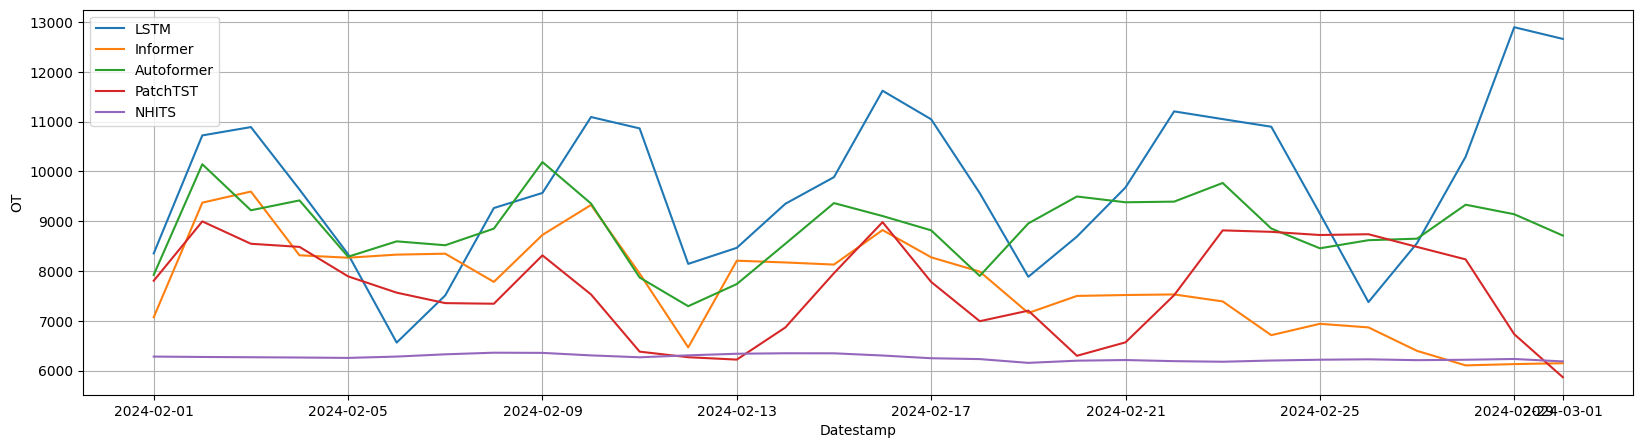

In [46]:
from matplotlib import pyplot as plt

Y_plot = df_pred[df_pred.index == 'global_entry']

plt.figure(figsize=(20, 5))
plt.plot(Y_plot['ds'], Y_plot['AutoLSTM'], label='LSTM')
plt.plot(Y_plot['ds'], Y_plot['AutoInformer'], label='Informer')
plt.plot(Y_plot['ds'], Y_plot['AutoAutoformer'], label='Autoformer')
plt.plot(Y_plot['ds'], Y_plot['AutoPatchTST'], label='PatchTST')
plt.plot(Y_plot['ds'], Y_plot['AutoNHITS'], label='NHITS')
plt.xlabel('Datestamp')
plt.ylabel('OT')
plt.grid()
plt.legend()

In [48]:
nf.save('./models',model_index = [0,1,2,3,4],overwrite=False,save_dataset = True)